cuda:0


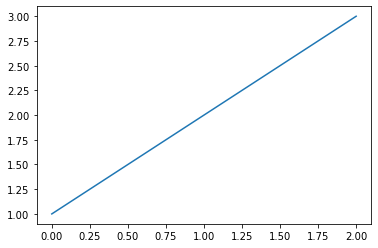

In [1]:
import importlib
from matplotlib import pyplot as plt
plt.plot([1,2,3])
from IPython.display import clear_output
import matplotlib
import numpy as np
import pandas as pd
import pdb
import time
from collections import deque, namedtuple
import torch
import cv2
from Environment.Env_new import RealExpEnv
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step
from Environment.episode_memory import Episode_Memory
from Environment.get_atom_coordinate import atom_detection, blob_detection, get_atom_coordinate_nm
from skimage import morphology, measure
from Environment.createc_control import Createc_Controller
import glob
from collections import deque
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [51]:
import Environment.data_visualization
importlib.reload(Environment.data_visualization)
from Environment.data_visualization import plot_graph, show_reset, show_done, show_step

In [49]:
import Environment.Env_new
importlib.reload(Environment.Env_new)
from Environment.Env_new import RealExpEnv

In [30]:
import RL.sac
importlib.reload(RL.sac)
from RL.sac import sac_agent, ReplayMemory, HerReplayMemory

In [3]:
# run this if want to reset env but keep the memory
import copy
amd_accuracy = copy.copy(env.accuracy)
print(amd_accuracy)
amd_true_positive = copy.copy(env.true_positive)
print(amd_true_positive)
amd_true_negative = copy.copy(env.true_negative)
print(amd_true_negative)
amd = copy.copy(env.atom_move_detector)

NameError: name 'env' is not defined

succeed to connect
(128, 128)


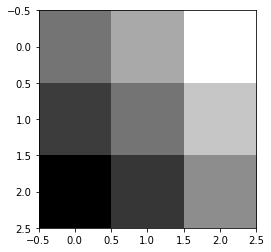

In [2]:
createc_controller = Createc_Controller(None, None, None, None)
img_forward = np.array(createc_controller.stm.scandata(1,4))
print(img_forward.shape)
top_left, w, h = (5,3), 3, 3
template = img_forward[top_left[1]:top_left[1]+h, top_left[0]:top_left[0]+w]
plt.imshow(template)

In [70]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
pixel = 128

im_size_nm = 6
x_nm, y_nm = createc_controller.get_offset_nm()
offset_nm = np.array([x_nm, y_nm])
manip_limit_nm = np.array([x_nm - 0.5*im_size_nm+0.5, x_nm + 0.5*im_size_nm-0.5, y_nm+0.5, y_nm+im_size_nm-0.5]) #[left, right, up, down]
template_max_y = 3
scan_mV = 1000
max_len = 5
pull_back_mV = 10
pull_back_pA = 57000
env = RealExpEnv(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 template, current_jump, im_size_nm, offset_nm, manip_limit_nm, pixel, 
                 template_max_y, scan_mV, max_len, 
                 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_Ag/_atom_move_detector_conv.pth', 
                 bottom=False, random_scan_rate = 0.9, pull_back_mV = pull_back_mV,
                 pull_back_pA = pull_back_pA)


succeed to connect
Load cnn weight


In [165]:
# run this if want to reset env but keep the memory
env.accuracy = amd_accuracy
env.true_positive = amd_true_positive
env.true_negative = amd_true_negative
env.atom_move_detector = amd

In [57]:
print(len(memory))
memory = HerReplayMemory(replay_size, env, strategy = 'future')
a_4, a_5 = [], [] 
for i, np_name in enumerate(glob.glob(folder_name+'/*.npy')):
    data = np.load(np_name,allow_pickle=True).item()
    transitions = data['transitions']
    for s, a, r, n, d, info in zip(transitions['state'], transitions['action'], transitions['reward'], 
                                   transitions['next_state'], transitions['done'], transitions['info']):
        a_4.append(a[4])
        a_5.append(a[5])
        mask = float(not d)
        memory.push(s, a, r, n, mask)
print(len(memory))

5449
5439


(array([414., 393., 409., 456., 413., 432., 457., 494., 544., 650.]),
 array([0.5012136 , 0.55098605, 0.60075843, 0.6505309 , 0.70030326,
        0.7500757 , 0.79984814, 0.8496205 , 0.89939296, 0.94916534,
        0.9989378 ], dtype=float32),
 <BarContainer object of 10 artists>)

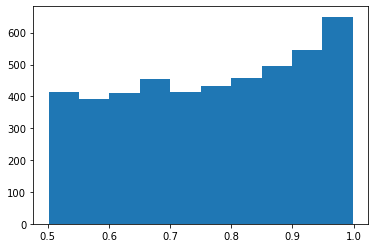

In [14]:
plt.hist(a_5)

(array([491., 504., 468., 401., 432., 409., 435., 484., 506., 532.]),
 array([0.33406997, 0.40063205, 0.4671941 , 0.5337562 , 0.60031825,
        0.66688037, 0.7334424 , 0.8000045 , 0.86656654, 0.93312865,
        0.9996907 ], dtype=float32),
 <BarContainer object of 10 artists>)

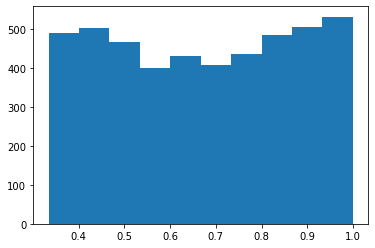

In [13]:
plt.hist(a_4)

In [587]:
# run this if want to reset env but keep the memory
buffer = memory.buffer
memory = HerReplayMemory(replay_size, env)
memory.buffer = buffer
print(len(memory))

6472


In [5]:
# ONLY RE-RUN if WANT TO RESET the AGENT
batch_size= 64
LEARNING_RATE = 0.0003
replay_size=1000000
i_episode = 1320
ACTION_SPACE = namedtuple('ACTION_SPACE', ['high', 'low'])
action_space = ACTION_SPACE(high = torch.tensor([1,1,1,1,1,1]), low = torch.tensor([-1,-1,-1,-1,1/3,1/2]))

alpha = torch.load('{}/_alpha_{}.pth'.format(folder_name,i_episode)).item()
print(alpha)
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = action_space, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=alpha)
agent.critic.load_state_dict(torch.load('{}/_critic_{}.pth'.format(folder_name,i_episode)))
agent.policy.load_state_dict(torch.load('{}/_policy_{}.pth'.format(folder_name,i_episode)))
memory = HerReplayMemory(replay_size, env, strategy = 'future')
print(agent.alpha)

0.2730022072792053
tensor([0.2730], device='cuda:0')


In [4]:
episode_memory = Episode_Memory()
folder_name = 'C:/LocalUserData/User-data/phys-asp-lab/auto_manipulation/training_Ag'

In [7]:
episode_rewards, alphas, precisions, episode_lengths = [], [], [], []
avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths = [], [], [], []

In [65]:
c_k_min = 2500
eta_0 = 0.996
eta_T = 1.0
n_interactions = 500
max_ep_len = max_len
eta = 0.997
def sac_train(max_steps, num_episodes = 50, episode_start = 0):
    for i_episode in range(episode_start,episode_start+num_episodes):
        print('Episode:', i_episode)
        eta_t = np.minimum(eta_0 + (eta_T - eta_0)*(i_episode/n_interactions), eta_T)
        episode_reward, episode_steps = 0, 0
        done = False
        state, info = env.reset(update_conv_net=True)
        show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm,
                   env.template_nm, env.template_wh)
        episode_memory.update_memory_reset(env.img_info, i_episode, info)
        
        for step in range(max_steps):
            print('step:', step)
            action = agent.select_action(state)
            old_atom_nm = env.atom_absolute_nm
            next_state, reward, done, info = env.step(action)
            print('reward', reward)
            
            episode_steps+=1
            episode_reward+=reward
            mask = float(not done)
            memory.push(state,action,reward,next_state,mask)
            episode_memory.update_memory_step(state, action, next_state, reward, done, info)
            show_step(env.img_info, info['start_nm']+old_atom_nm, info['end_nm']+old_atom_nm,
                        env.atom_absolute_nm, env.atom_start_absolute_nm, 
                        env.destination_absolute_nm, action[4]*env.max_mvolt, 
                        action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt, 
                        env.template_nm, env.template_wh)
            _, size= blob_detection(env.img_info['img_forward'])
            print('atom size:', size)
            print('Precision:', env.dist_destination)
            if done:
                episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, env.atom_relative_nm)
                episode_memory.save_memory(folder_name)
                
                atom_to_start = env.atom_relative_nm - env.atom_start_relative_nm
                print('Episode reward:', episode_reward)
                '''show_done(env.img_info, env.atom_absolute_nm, env.atom_start_absolute_nm, 
                          env.destination_absolute_nm, reward, env.template_nm, env.template_wh)'''
                break
            else:                
                state=next_state
             
        if (len(memory)>batch_size):
            episode_K = int(episode_steps)
            for k in range(episode_K):
                #c_k = max(int(memory.__len__()*eta_t**(k*(max_ep_len/episode_K))), c_k_min)
                c_k = memory.__len__()
                #print('TRAINING!')
                #c_k = max(int(memory.__len__()*eta**(k*(1000/episode_K))), 500)
                print(c_k)
                agent.update_parameters(memory, batch_size, c_k)
        
        episode_rewards.append(episode_reward)
        alphas.append(agent.alpha.item())
        precisions.append(env.dist_destination)
        episode_lengths.append(episode_steps)
        avg_episode_rewards.append(np.mean(episode_rewards[-min(100,len(episode_rewards)):]))
        avg_alphas.append(np.mean(alphas[-min(100, len(alphas)):]))
        avg_precisions.append(np.mean(precisions[-min(100, len(precisions)):]))
        avg_episode_lengths.append(np.mean(episode_lengths[-min(100, len(episode_lengths)):]))
        print('Average precision:',avg_precisions[-1])
        if avg_precisions[-1]<0.144:
            env.createc_controller.pixel = 256
        if (i_episode+1)%2==0:
            plot_graph(episode_rewards, precisions, alphas, episode_lengths,
                      avg_episode_rewards, avg_alphas, avg_precisions, avg_episode_lengths)
            
        if (i_episode)%20 == 0:
            torch.save(agent.critic.state_dict(), '{}/_critic_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.policy.state_dict(), '{}/_policy_{}.pth'.format(folder_name,i_episode))
            torch.save(agent.alpha, '{}/_alpha_{}.pth'.format(folder_name,i_episode))


Episode: 1751
The scan will take 8.5 seconds
goal_nm: 1.5632406298931123


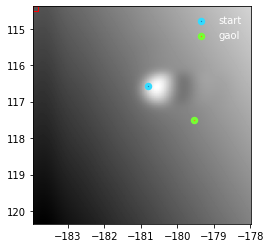

step: 0
76 46 97 66
Prediction: 0.81811506
CNN prediction: 0.81811506 Old prediction: True
cnn thinks there is atom movement
The scan will take 8.5 seconds
atom moves by: 1.399 nm
reward 3.7867234507140553


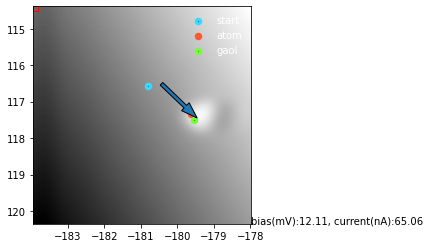

atom size: [8.60752869]
Precision: 0.18466427608746297
step: 1
99 62 97 66
Prediction: 0.6371479
CNN prediction: 0.6371479 Old prediction: True
cnn thinks there is atom movement
The scan will take 8.5 seconds
atom moves by: 1.452 nm
reward -1.2852094660725322


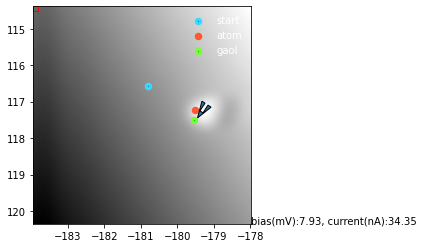

atom size: [10.10437012]
Precision: 0.2668046023163504
step: 2
88 56 93 69
Prediction: 0.9385828
CNN prediction: 0.9385828 Old prediction: True
cnn thinks there is atom movement
The scan will take 8.5 seconds
atom moves by: 1.235 nm
reward -1.2242740365971896


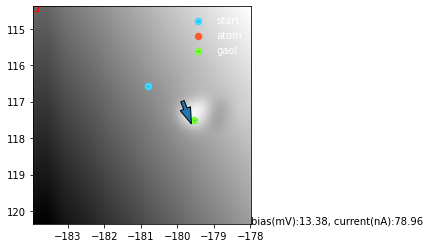

atom size: [7.72329712]
Precision: 0.331395524856344
step: 3
87 62 93 74
Prediction: 0.322005
CNN prediction: 0.322005 Old prediction: False
CNN and old prediction both say no movement
reward -1.0000000000000002


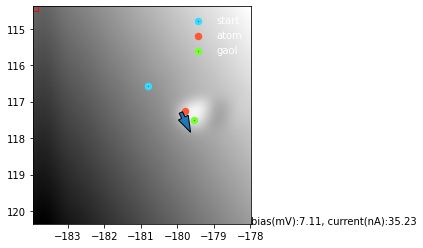

atom size: [7.72329712]
Precision: 0.331395524856344
step: 4
88 68 97 71
The scan will take 8.5 seconds


KeyboardInterrupt: 

In [71]:
sac_train(max_steps=max_len, episode_start = 1751,num_episodes = 1000)

episode 460: experiment stops for work on the setup, tip could change
episode 602: experiment stops for building, tip could change
episode 620: cluster, tip could change
episode 640: tip forming
episode 1338: likely drastic tip change
episode 1420: likely drastic tip change
episode 1463: likely drastic tip change

In [168]:
torch.save(env.atom_move_detector.conv.state_dict(), '{}/_atom_move_detector_conv.pth'.format(folder_name))

In [66]:
env.atom_absolute_nm = None